# Codes for EDA

This notebook explores the dataset of `XYZ_Bank_Deposit_Data_Classification.csv` including 
- Basic data understanding
- Check for missing values
- Univariate analysis
- Bivariate analysis
- Correlation matirx
- Transformation Check

In [1]:
import findspark
findspark.init()

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc, desc, sum, avg, max, min, count, countDistinct, round, when, lit, log1p, sqrt, cbrt, log
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Bank Deposit Classification Mini Project") \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory', '32G') \
    .config('spark.executor.memory', '4g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC') \
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC') \
    .config('spark.network.timeout', '800s') \
    .config('spark.executor.heartbeatInterval', '60s') \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)


C:\Users\frank\apps\spark-3.5.0-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

schema = StructType([
    StructField("Age", IntegerType()),
    StructField("Job", StringType()),
    StructField("Marital", StringType()),
    StructField("Education", StringType()),
    StructField("Default", StringType()),
    StructField("Housing", StringType()),
    StructField("Loan", StringType()),
    StructField("Contact", StringType()),
    StructField("Month", StringType()),
    StructField("Day_of_week", StringType()),
    StructField("Duration", IntegerType()),
    StructField("Campaign", IntegerType()),
    StructField("Pdays", IntegerType()),
    StructField("Previous", IntegerType()),
    StructField("Poutcome", StringType()),
    StructField("Emp_var_rate", DoubleType()),
    StructField("Cons_price_idx", DoubleType()),
    StructField("Cons_conf_idx", DoubleType()),
    StructField("Euribor3m", DoubleType()),
    StructField("Nr_employed", DoubleType()),
    StructField("y", StringType())
])

df = spark.read.csv("XYZ_Bank_Deposit_Data_Classification.csv", header=True, schema=schema, sep=";")
df.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|Age|        Job| Marital|          Education|Default|Housing|Loan|  Contact|Month|Day_of_week|Duration|Campaign|Pdays|Previous|   Poutcome|Emp_var_rate|Cons_price_idx|Cons_conf_idx|Euribor3m|Nr_employed|  y|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57|   services| married|        high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.

In [3]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Job: string (nullable = true)
 |-- Marital: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Default: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- Loan: string (nullable = true)
 |-- Contact: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day_of_week: string (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Campaign: integer (nullable = true)
 |-- Pdays: integer (nullable = true)
 |-- Previous: integer (nullable = true)
 |-- Poutcome: string (nullable = true)
 |-- Emp_var_rate: double (nullable = true)
 |-- Cons_price_idx: double (nullable = true)
 |-- Cons_conf_idx: double (nullable = true)
 |-- Euribor3m: double (nullable = true)
 |-- Nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



# EDA

## Basic Understanding

In [4]:
df.describe().show()

+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+-----------------+-----------------+-------------------+--------+-------------------+------------------+-------------------+------------------+-----------------+-----+
|summary|               Age|    Job| Marital|Education|Default|Housing| Loan|  Contact|Month|Day_of_week|          Duration|         Campaign|            Pdays|           Previous|Poutcome|       Emp_var_rate|    Cons_price_idx|      Cons_conf_idx|         Euribor3m|      Nr_employed|    y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+-----------------+-----------------+-------------------+--------+-------------------+------------------+-------------------+------------------+-----------------+-----+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|    41188|41188|      41188|             41188|

## Check for Missing Values

In [5]:
from pyspark.sql.functions import col, sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|Age|Job|Marital|Education|Default|Housing|Loan|Contact|Month|Day_of_week|Duration|Campaign|Pdays|Previous|Poutcome|Emp_var_rate|Cons_price_idx|Cons_conf_idx|Euribor3m|Nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



## Univariate Analysis

In [6]:
# Numerical Variables
numerical_vars = [c for c, dtype in df.dtypes if dtype in ['int', 'double']]
df.select(numerical_vars).describe().show()

+-------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+------------------+-------------------+------------------+-----------------+
|summary|               Age|          Duration|         Campaign|            Pdays|           Previous|       Emp_var_rate|    Cons_price_idx|      Cons_conf_idx|         Euribor3m|      Nr_employed|
+-------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+------------------+-------------------+------------------+-----------------+
|  count|             41188|             41188|            41188|            41188|              41188|              41188|             41188|              41188|             41188|            41188|
|   mean| 40.02406040594348| 258.2850101971448|2.567592502670681|962.4754540157328|0.17296299893172767|0.08188550063178966|  93.5756643682899|-40.502600271918276| 3.621290812858533|5167.035910943957|


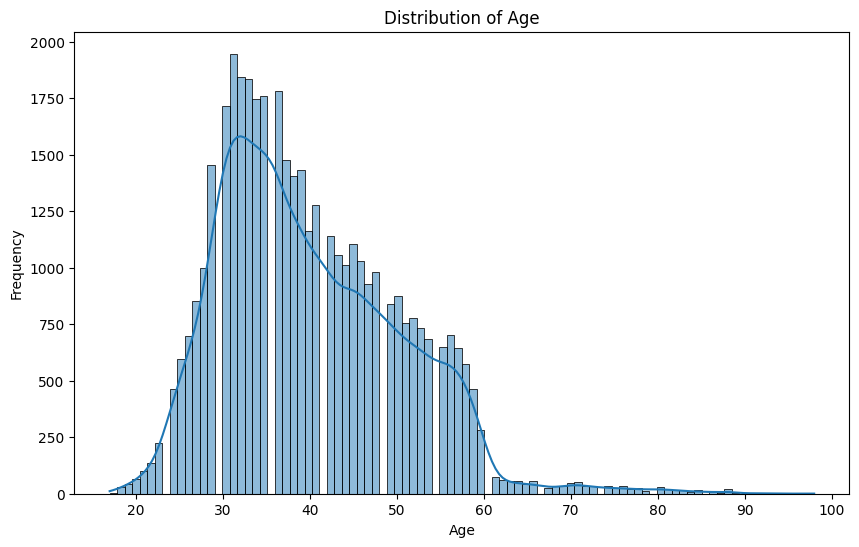

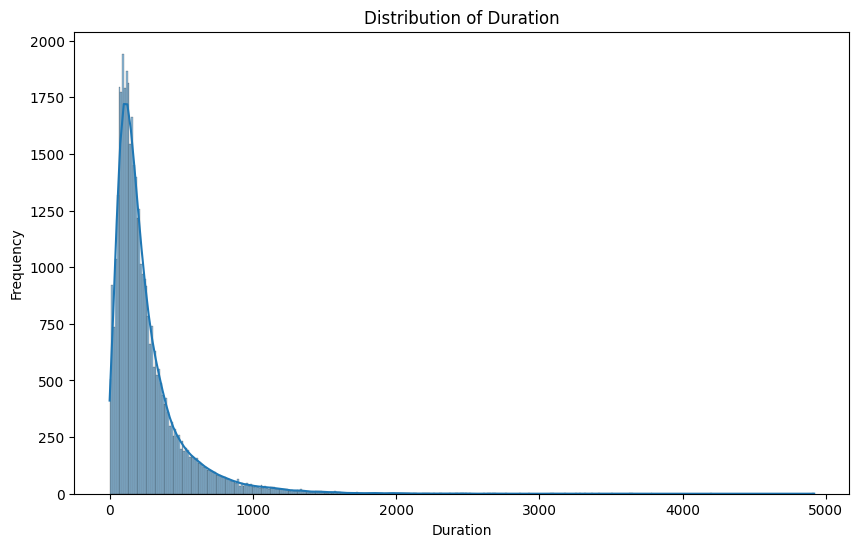

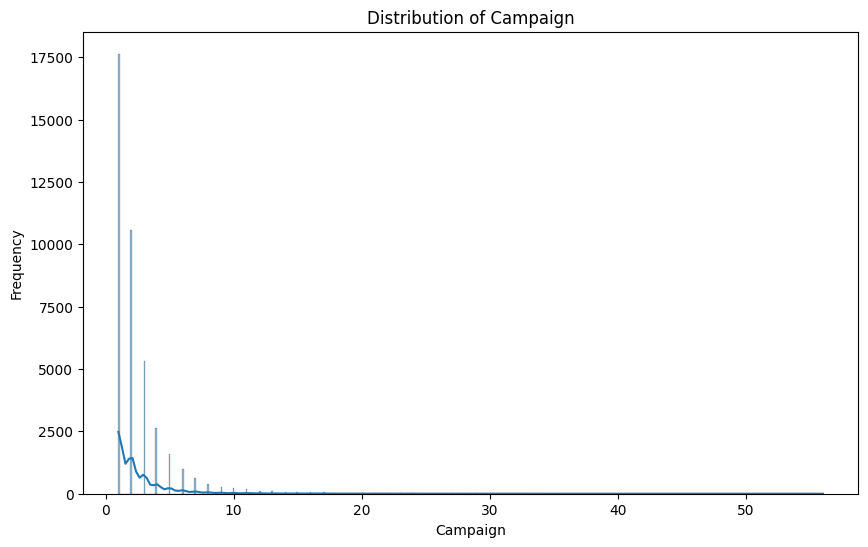

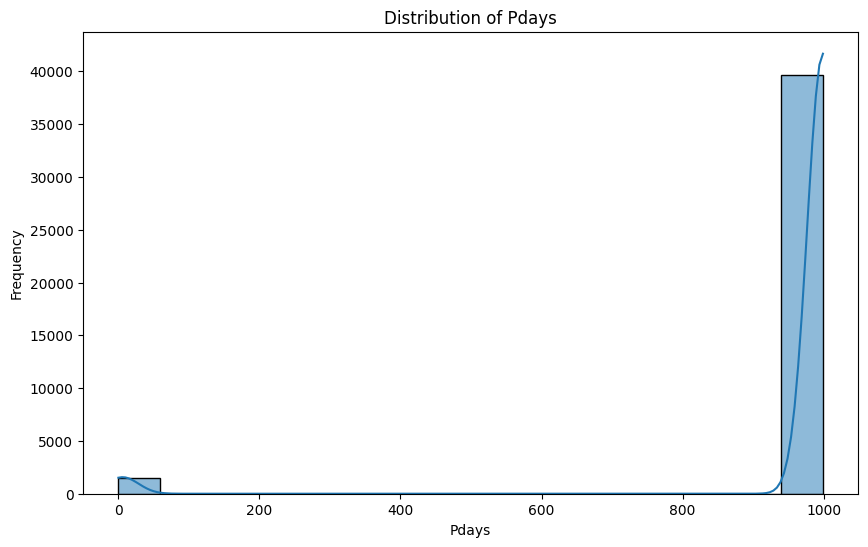

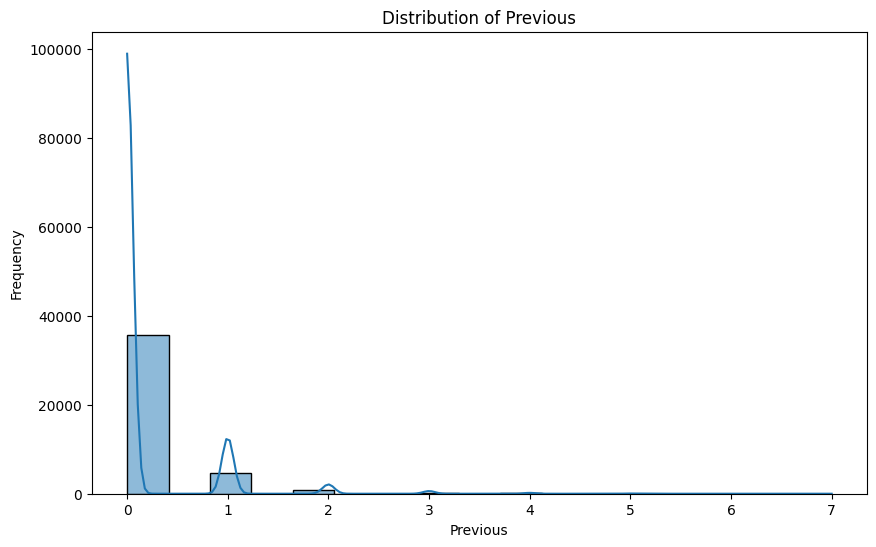

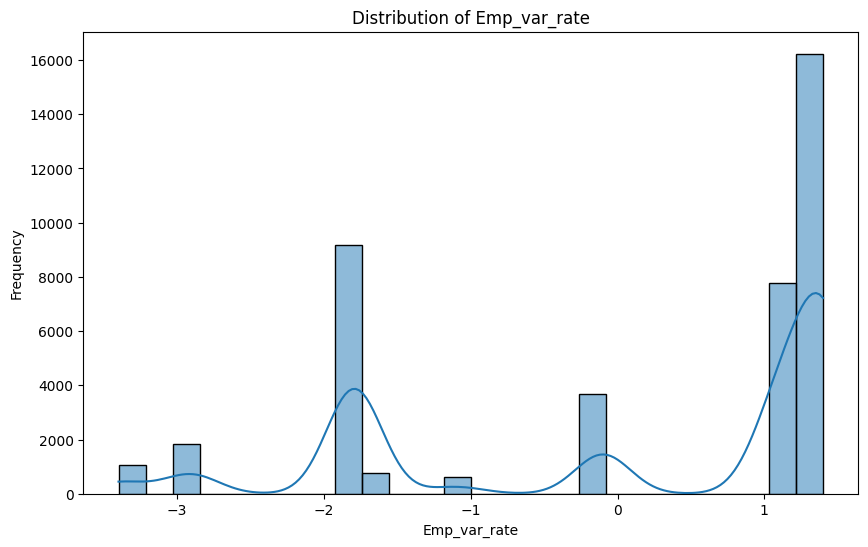

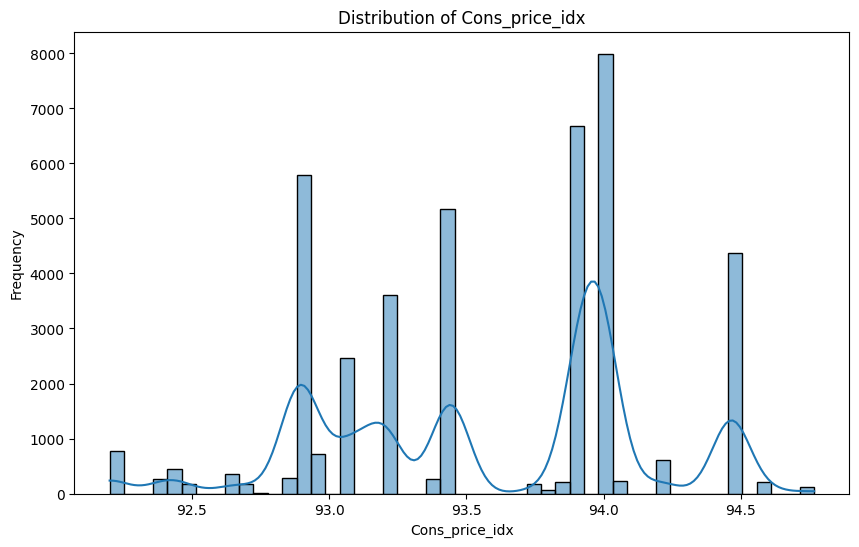

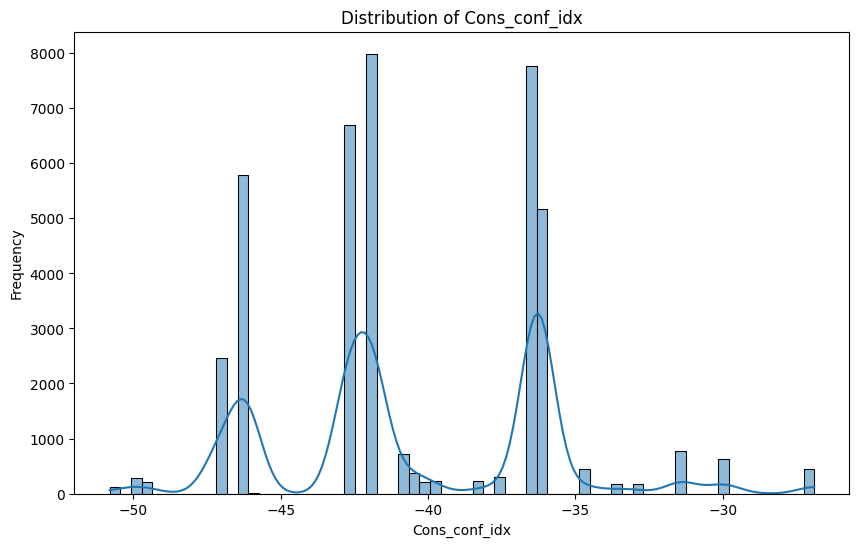

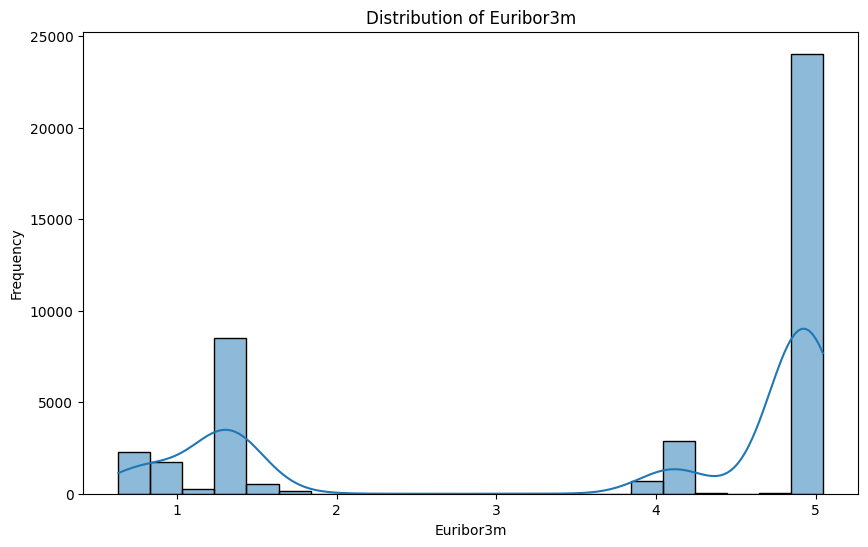

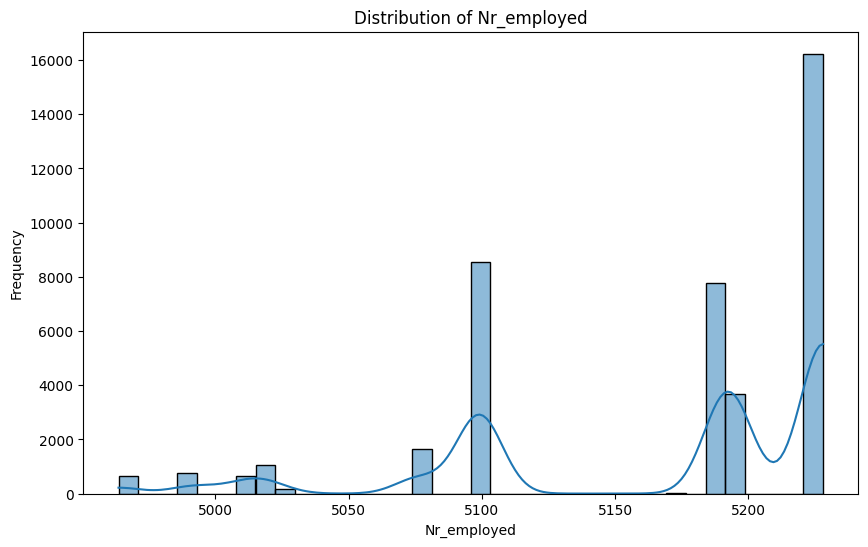

In [45]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
# Limiting the data for visualization
pandas_df = df.toPandas()  

# List of numerical columns
numerical_vars = [c for c, dtype in df.dtypes if dtype in ['int', 'double']]

# Plotting histograms for each numerical column
for col in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.histplot(pandas_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.savefig(f'EDA//univariate//{col}.png', bbox_inches='tight')


+-----+
|Pdays|
+-----+
|    1|
|    6|
|    3|
|    5|
|    9|
|    4|
|    8|
|    7|
|   10|
|   11|
|    2|
|  999|
|    0|
|   26|
|   27|
|   12|
|   22|
|   13|
|   16|
|   20|
+-----+
only showing top 20 rows



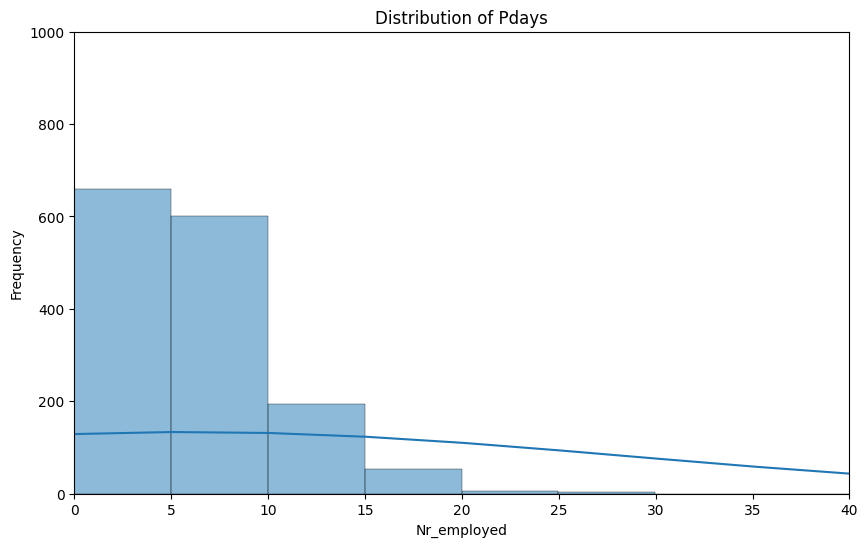

In [46]:
# Pdays are slightly different because of 999 that means not contacted before
df.select('Pdays').distinct().show()

# Convert Spark DataFrame to Pandas DataFrame for visualization
# Limiting the data for visualization
pandas_df = df.toPandas()  

plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['Pdays'], kde=True, bins=200)
plt.xlim(0,40)
plt.ylim(0,1000)
plt.title(f'Distribution of Pdays')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.savefig(f'EDA//univariate//Pdays.png', bbox_inches='tight')

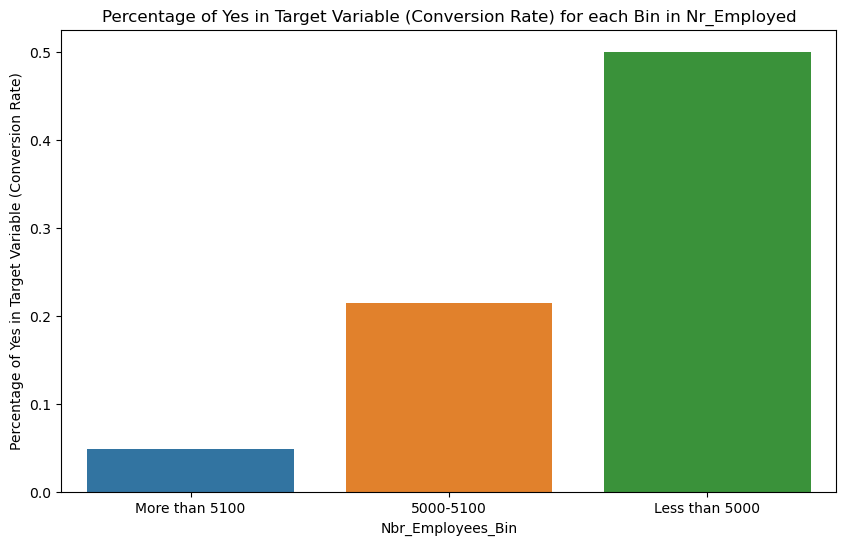

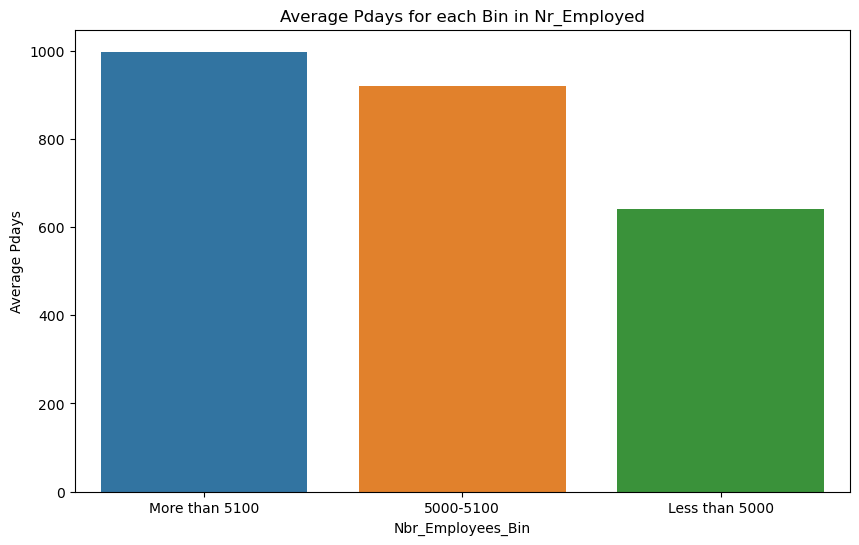

In [20]:
# bin number of employees Less than 5000, 5000-5100 and more than 5100
def helper_function_nbr_employees_bin(y):
    if y < 5000:
        return "Less than 5000"
    elif y >= 5000 and y < 5100:
        return "5000-5100"
    else:
        return "More than 5100"

udf_nr_employed = udf(helper_function_nbr_employees_bin, StringType())
df = df.withColumn("Nbr_Employees_Bin", udf_nr_employed('Nr_employed'))


pDays_target_bivariate_analysis = df.groupBy('Nbr_Employees_Bin').agg(
    (F.sum(F.when(F.col('y') == 'yes', 1).otherwise(0)) / F.count(F.col('y'))).alias('y_yes_perc'),
    (F.avg(F.col('Pdays'))).alias('avg_pdays')
).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Nbr_Employees_Bin', y='y_yes_perc', data=pDays_target_bivariate_analysis)
plt.title('Percentage of Yes in Target Variable (Conversion Rate) for each Bin in Nr_Employed')
plt.xlabel('Nbr_Employees_Bin')
plt.ylabel('Percentage of Yes in Target Variable (Conversion Rate)')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Nbr_Employees_Bin', y='avg_pdays', data=pDays_target_bivariate_analysis)
plt.title('Average Pdays for each Bin in Nr_Employed')
plt.xlabel('Nbr_Employees_Bin')
plt.ylabel('Average Pdays')
plt.show()


+-------------+-----+
|          Job|count|
+-------------+-----+
|       admin.|10422|
|  blue-collar| 9254|
|   technician| 6743|
|     services| 3969|
|   management| 2924|
|      retired| 1720|
| entrepreneur| 1456|
|self-employed| 1421|
|    housemaid| 1060|
|   unemployed| 1014|
|      student|  875|
|      unknown|  330|
+-------------+-----+

+--------+-----+
| Marital|count|
+--------+-----+
| married|24928|
|  single|11568|
|divorced| 4612|
| unknown|   80|
+--------+-----+

+-------------------+-----+
|          Education|count|
+-------------------+-----+
|  university.degree|12168|
|        high.school| 9515|
|           basic.9y| 6045|
|professional.course| 5243|
|           basic.4y| 4176|
|           basic.6y| 2292|
|            unknown| 1731|
|         illiterate|   18|
+-------------------+-----+

+-------+-----+
|Default|count|
+-------+-----+
|     no|32588|
|unknown| 8597|
|    yes|    3|
+-------+-----+

+-------+-----+
|Housing|count|
+-------+-----+
|    yes|215

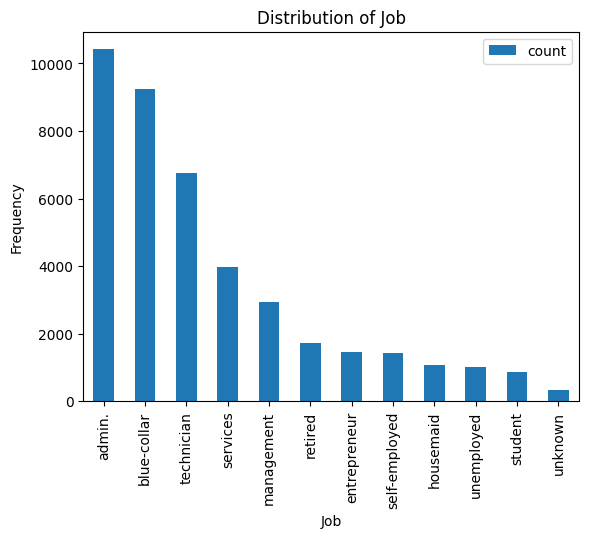

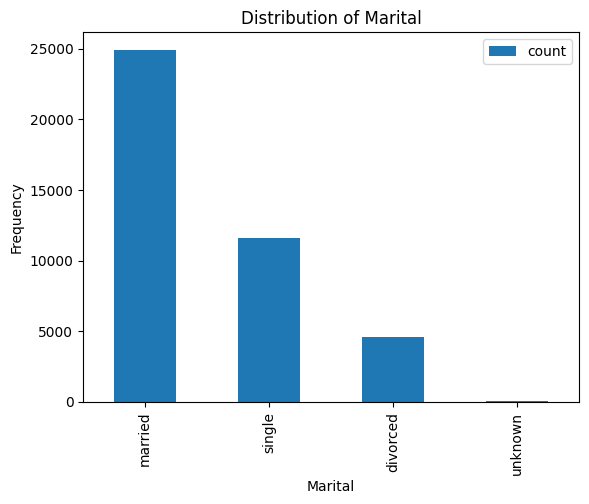

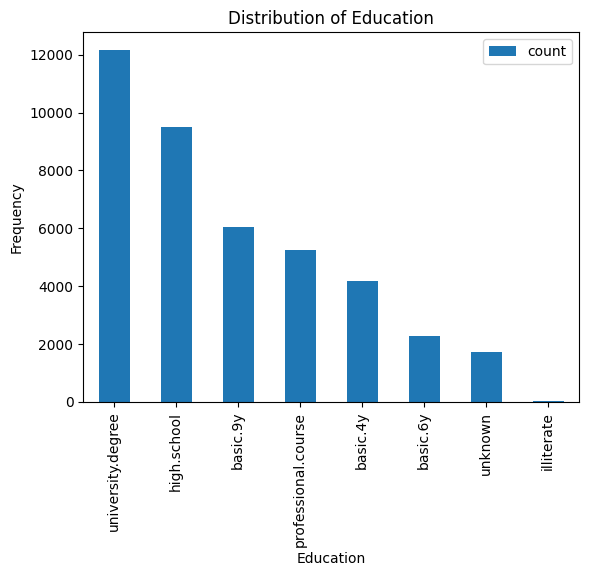

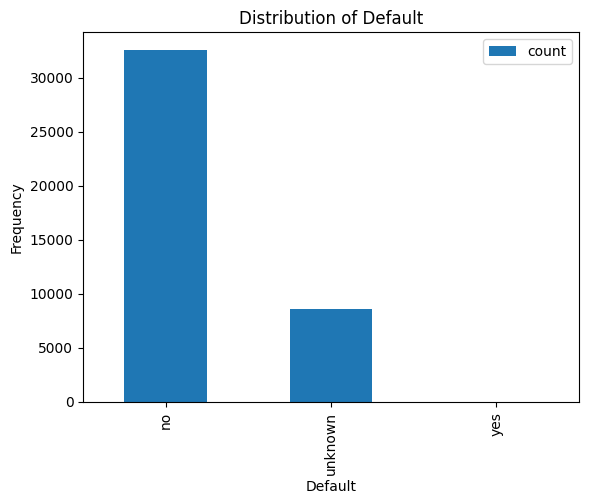

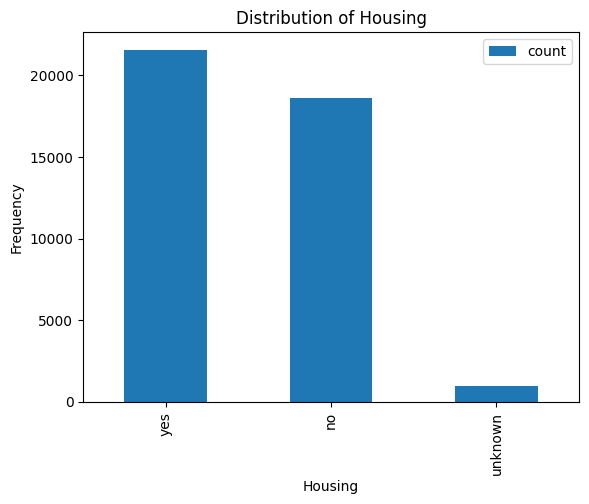

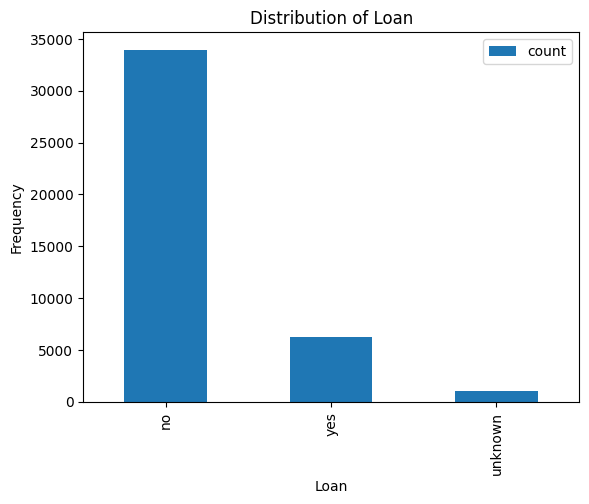

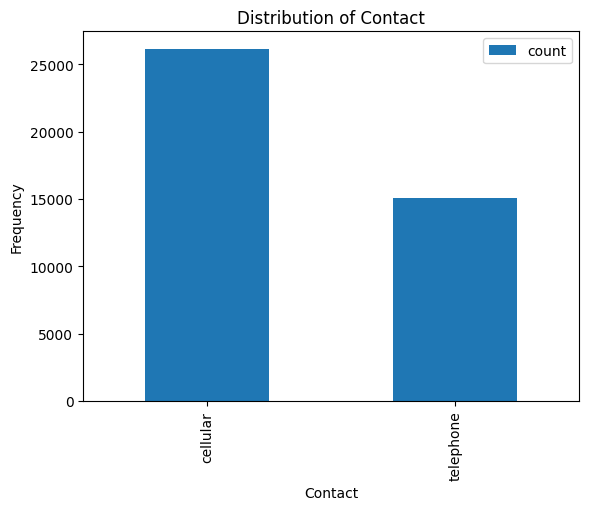

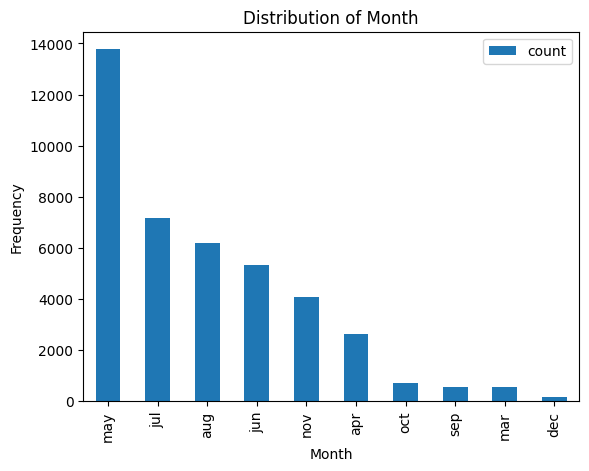

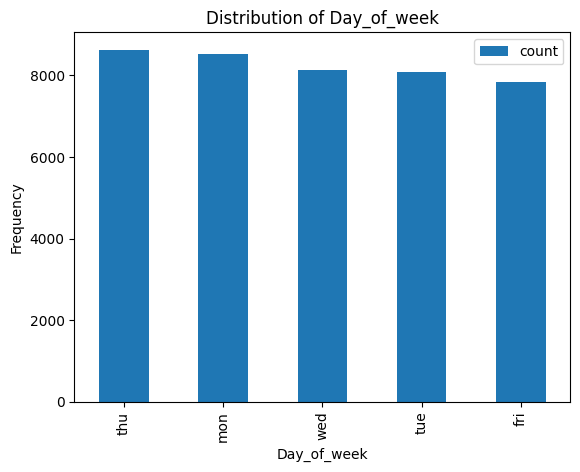

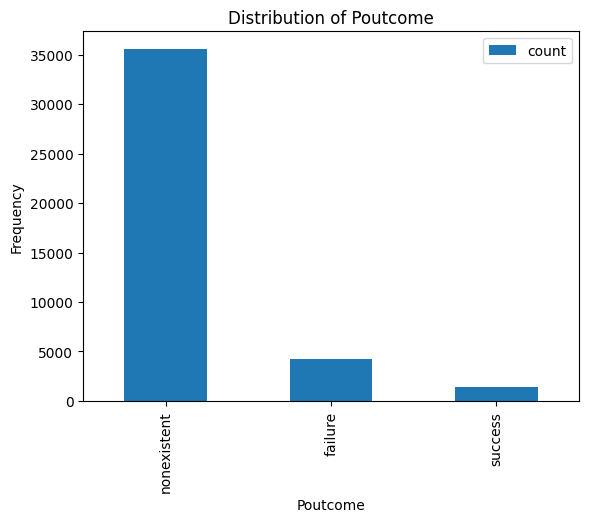

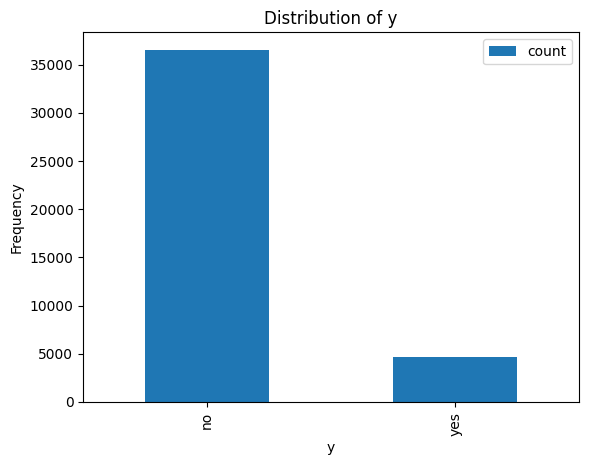

In [47]:
# Categorical Variables
categorical_vars = [c for c, dtype in df.dtypes if dtype == 'string']
for col in categorical_vars:
    df.groupBy(col).count().orderBy("count", ascending=False).show()

# Plot the distribution of the categorical variables
for col in categorical_vars:
    df.groupBy(col).count().orderBy("count", ascending=False).toPandas().plot.bar(col)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.savefig(f'EDA//univariate//{col}.png', bbox_inches='tight')

## Bivariate Analysis

In [48]:
for col in categorical_vars:
    df.groupBy(col, 'y').count().show()

+-------------+---+-----+
|          Job|  y|count|
+-------------+---+-----+
|       admin.| no| 9070|
|      retired|yes|  434|
|   management| no| 2596|
|  blue-collar| no| 8616|
|      student| no|  600|
|      unknown| no|  293|
|   technician| no| 6013|
|       admin.|yes| 1352|
|   management|yes|  328|
|  blue-collar|yes|  638|
|      unknown|yes|   37|
|   unemployed| no|  870|
|self-employed|yes|  149|
|    housemaid|yes|  106|
|   unemployed|yes|  144|
|   technician|yes|  730|
|     services|yes|  323|
|self-employed| no| 1272|
|    housemaid| no|  954|
| entrepreneur|yes|  124|
+-------------+---+-----+
only showing top 20 rows

+--------+---+-----+
| Marital|  y|count|
+--------+---+-----+
|divorced|yes|  476|
| unknown| no|   68|
|  single| no| 9948|
|  single|yes| 1620|
|divorced| no| 4136|
| unknown|yes|   12|
| married|yes| 2532|
| married| no|22396|
+--------+---+-----+

+-------------------+---+-----+
|          Education|  y|count|
+-------------------+---+-----+
|

In [49]:
from pyspark.sql.functions import col

result_dfs = []
for col_name in categorical_vars:
    if col_name != "y":
        # Count the occurrences of each category
        count_df = df.groupBy(col_name, 'y').count()

        # Calculate the total count for each category
        total_count_df = df.groupBy(col_name).count().withColumnRenamed("count", "total_count")

        # Join the count with the total count
        percentage_df = count_df.join(total_count_df, col_name)

        # Calculate the percentage
        percentage_df = percentage_df.withColumn("percentage", col("count") / col("total_count") * 100)

        # Keep the dataframe for later plotting
        result_dfs.append(percentage_df)


In [50]:
result_dfs

[+-------------+---+-----+-----------+------------------+
 |          Job|  y|count|total_count|        percentage|
 +-------------+---+-----+-----------+------------------+
 |   management|yes|  328|       2924| 11.21751025991792|
 |   management| no| 2596|       2924| 88.78248974008208|
 |      retired| no| 1286|       1720| 74.76744186046511|
 |      retired|yes|  434|       1720|25.232558139534884|
 |      unknown|yes|   37|        330|11.212121212121213|
 |      unknown| no|  293|        330|  88.7878787878788|
 |self-employed| no| 1272|       1421| 89.51442646023928|
 |self-employed|yes|  149|       1421| 10.48557353976073|
 |      student|yes|  275|        875|31.428571428571427|
 |      student| no|  600|        875| 68.57142857142857|
 |  blue-collar|yes|  638|       9254| 6.894315971471795|
 |  blue-collar| no| 8616|       9254|  93.1056840285282|
 | entrepreneur| no| 1332|       1456| 91.48351648351648|
 | entrepreneur|yes|  124|       1456| 8.516483516483516|
 |       admin

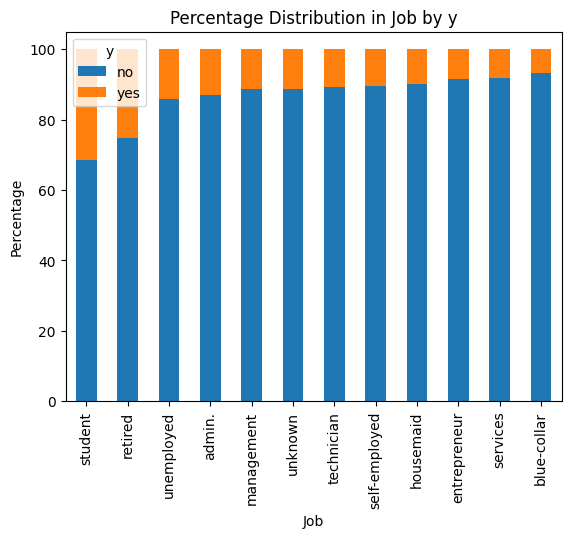

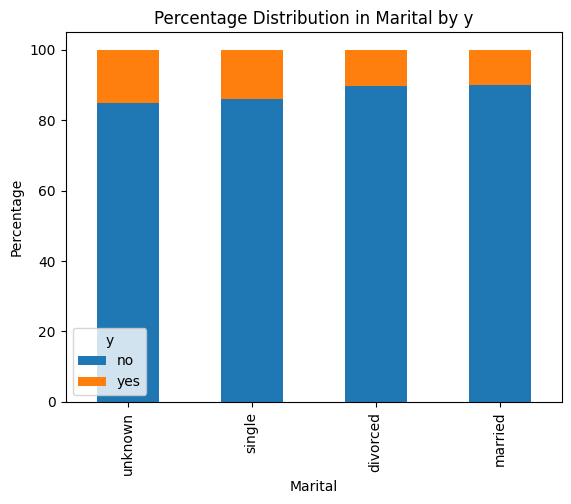

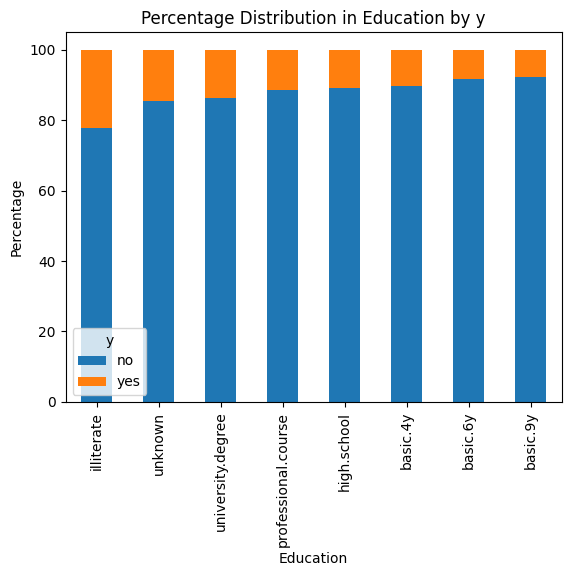

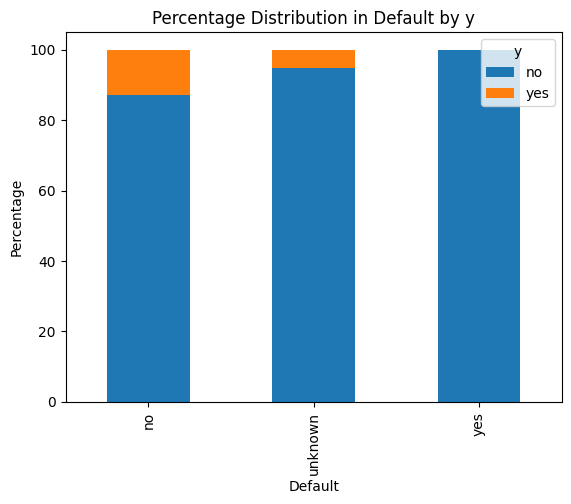

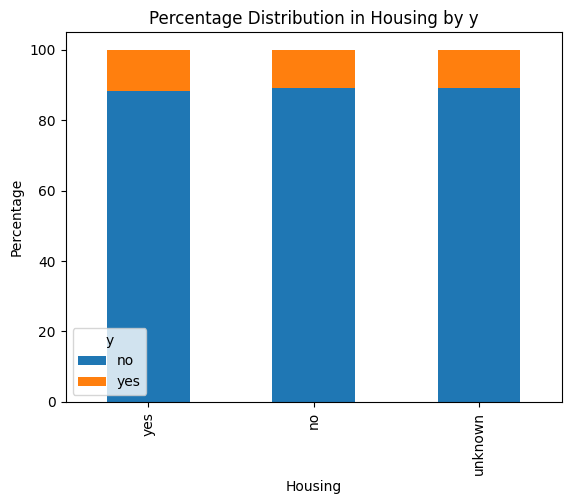

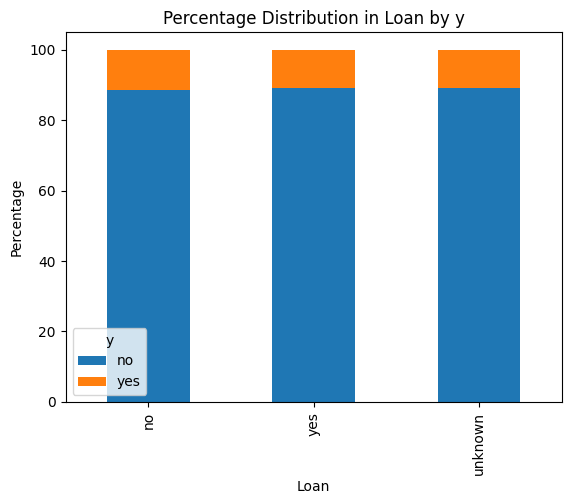

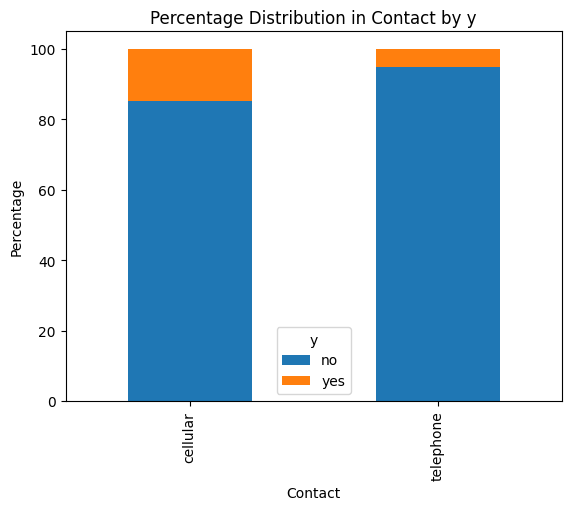

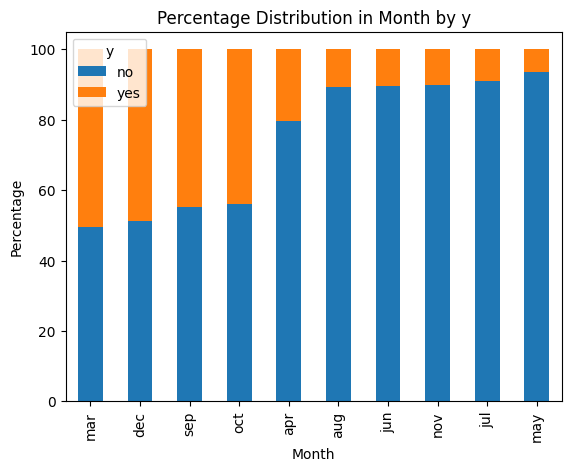

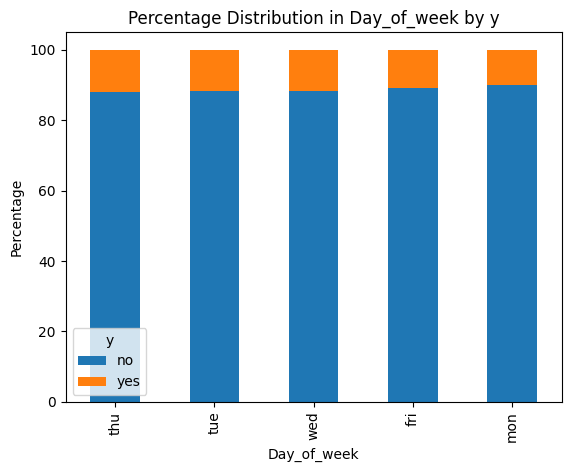

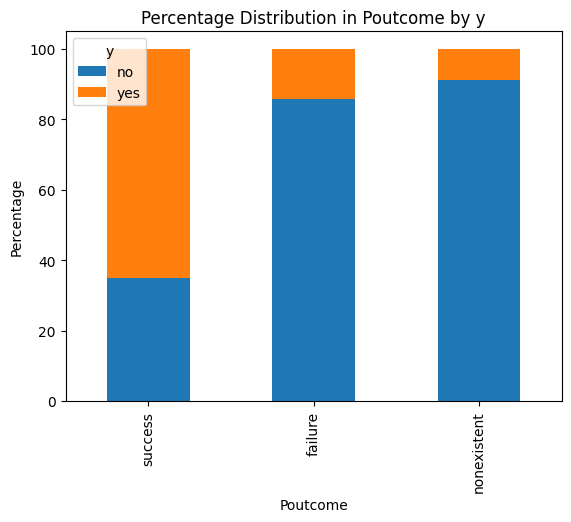

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

for percentage_df in result_dfs:
    # Convert to Pandas DataFrame
    pandas_df = percentage_df.toPandas()

    # Pivot for better plotting
    pivot_df = pandas_df.pivot(index=percentage_df.columns[0], columns='y', values='percentage')

    # Sort by percentage of 'yes' in descending order
    pivot_df = pivot_df.sort_values(by='yes', ascending=False)

    # Plotting
    pivot_df.plot(kind='bar', stacked=True)
    plt.ylabel('Percentage')
    plt.title(f'Percentage Distribution in {percentage_df.columns[0]} by y')
    plt.savefig(f'EDA//bivariate//{percentage_df.columns[0]}.png', bbox_inches='tight')
    plt.show()


## Correlation Analysis

In [52]:
df = df.drop('label')

In [53]:
# label encode y variable and create correlation matrix for numerical variables including label encoded y variable
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# label encode y variable
indexer = StringIndexer(inputCol="y", outputCol="label")
df = indexer.fit(df).transform(df)

In [54]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,Age,Duration,Campaign,Pdays,Previous,Emp_var_rate,Cons_price_idx,Cons_conf_idx,Euribor3m,Nr_employed,label
Age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
Duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
Campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
Pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
Previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
Emp_var_rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
Cons_price_idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
Cons_conf_idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
Euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
Nr_employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


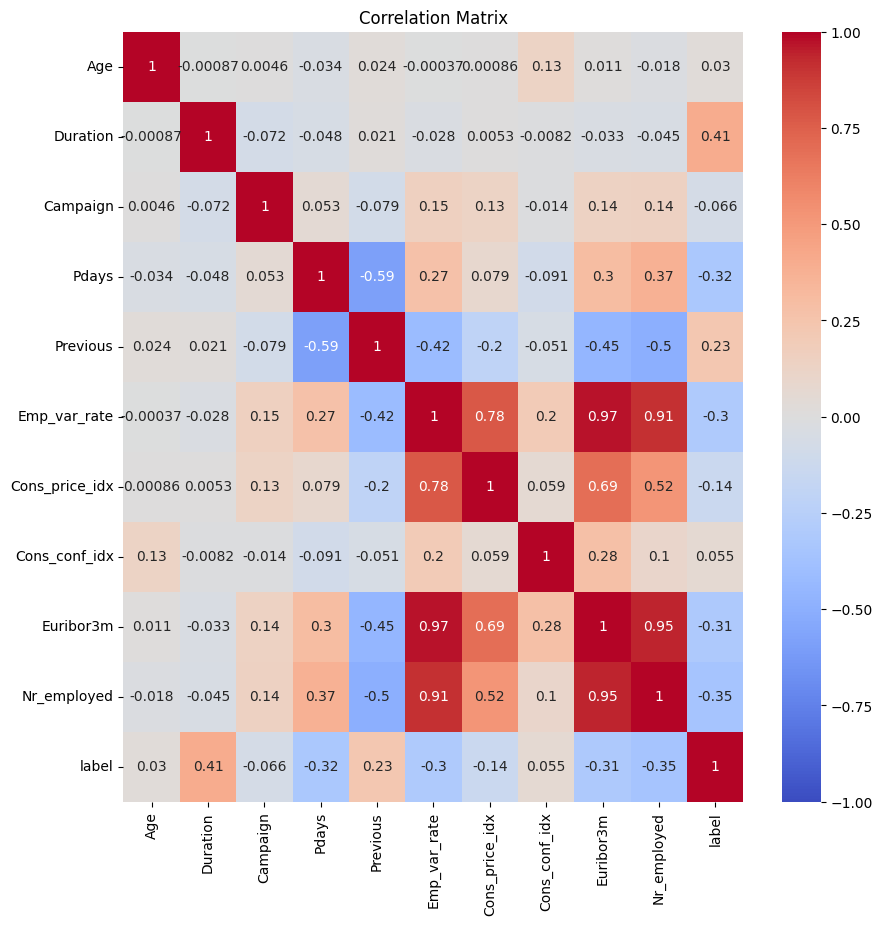

In [55]:
# plot correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.savefig(f'EDA//correlation_matrix.png', bbox_inches='tight')
plt.show()


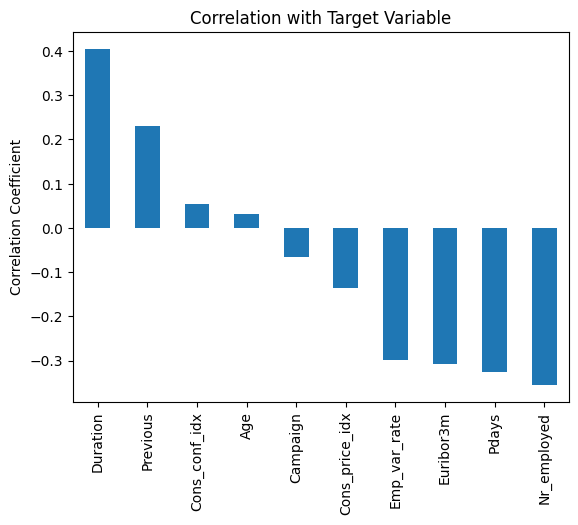

In [56]:
# plot correlation bar plot to label
corr_df['label'].sort_values(ascending=False).drop('label').plot.bar()
plt.title("Correlation with Target Variable")
plt.ylabel("Correlation Coefficient")
plt.savefig(f'EDA//correlation_barplot.png', bbox_inches='tight')

## Transformation Check
- binary encoding: pdays (999 means no contact)
- log+1: campaign, duration

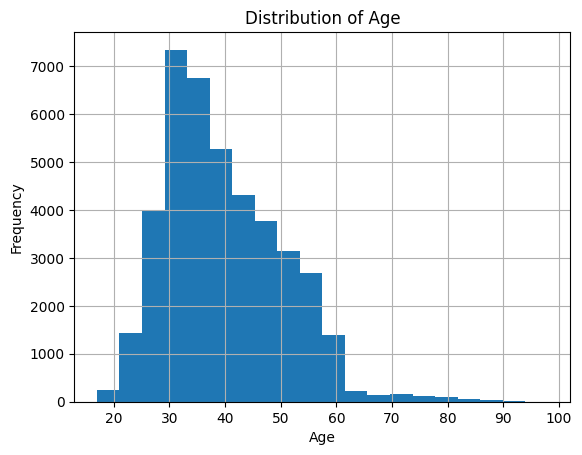

In [57]:
# plot transformed age with bins
df.select('age').toPandas().hist(bins=20)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

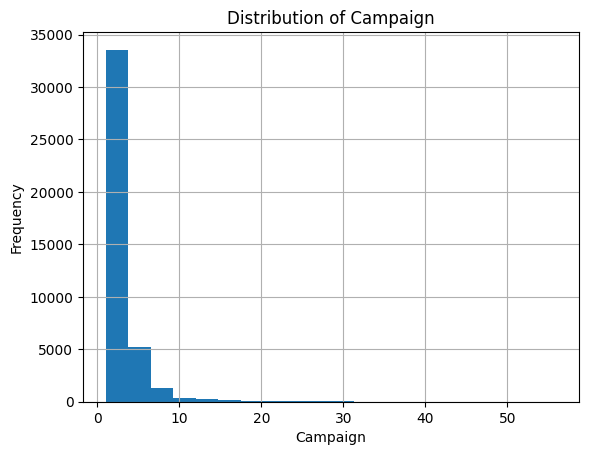

In [60]:
# plot campaign with bins
df.select('campaign').toPandas().hist(bins=20)
plt.title("Distribution of Campaign")
plt.xlabel("Campaign")
plt.ylabel("Frequency")
plt.show()


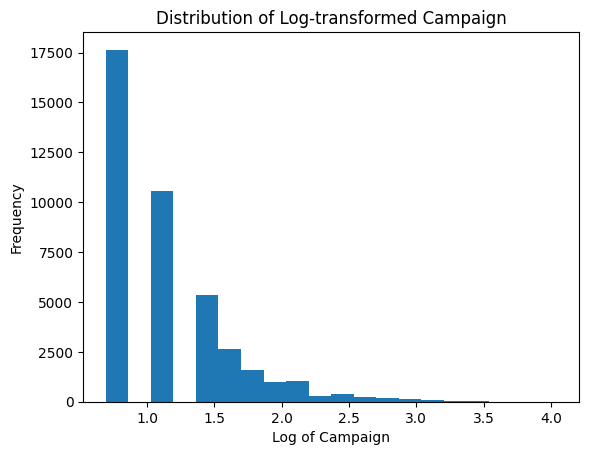

In [73]:

# Assuming 'df' is your Spark DataFrame and 'campaign' is the column you wish to transform.
# Apply logarithmic transformation to 'campaign'.
df = df.withColumn("campaign_log", log1p("campaign"))

# Now, you would plot the distribution of the transformed 'campaign' to evaluate the result.
# The following code would be executed in a PySpark environment that supports plotting, like Databricks.
# For local environments, you would collect the data to the driver node and use a local plotting library like matplotlib.

# Collect the data to the driver node. Be cautious with large datasets as this can cause out-of-memory errors.
campaign_log_data = df.select('campaign_log').rdd.flatMap(lambda x: x).collect()

# Use matplotlib to plot the histogram.
import matplotlib.pyplot as plt

plt.hist(campaign_log_data, bins=20)
plt.title('Distribution of Log-transformed Campaign')
plt.xlabel('Log of Campaign')
plt.ylabel('Frequency')
plt.show()


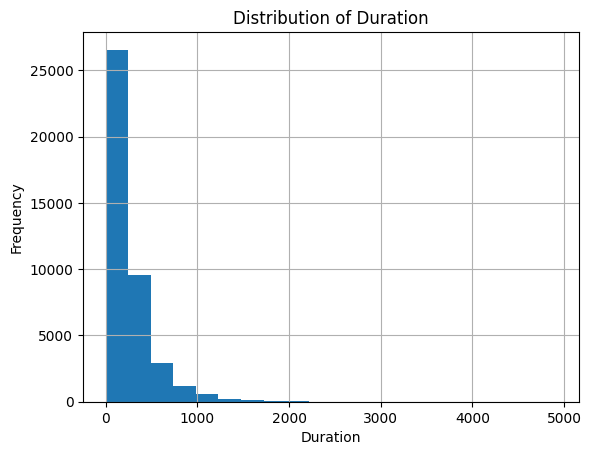

In [74]:
# plot campaign with bins
df.select('duration').toPandas().hist(bins=20)
plt.title("Distribution of Duration")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.show()


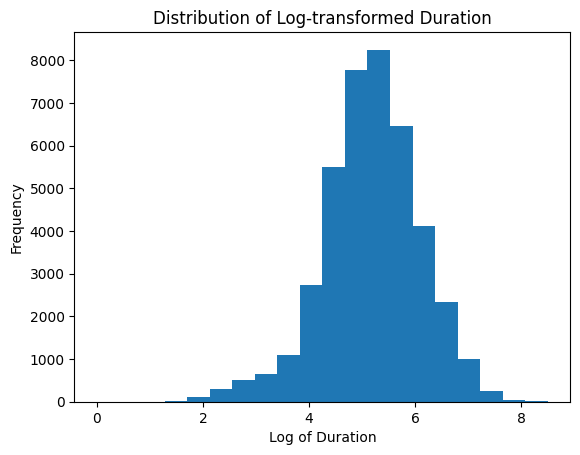

In [75]:
# Assuming 'df' is your Spark DataFrame and 'campaign' is the column you wish to transform.
# Apply logarithmic transformation to 'campaign'.
df = df.withColumn("duration_log", log1p("duration"))

# Now, you would plot the distribution of the transformed 'campaign' to evaluate the result.
# The following code would be executed in a PySpark environment that supports plotting, like Databricks.
# For local environments, you would collect the data to the driver node and use a local plotting library like matplotlib.

# Collect the data to the driver node. Be cautious with large datasets as this can cause out-of-memory errors.
duration_log_data = df.select('duration_log').rdd.flatMap(lambda x: x).collect()

# Use matplotlib to plot the histogram.
import matplotlib.pyplot as plt

plt.hist(duration_log_data, bins=20)
plt.title('Distribution of Log-transformed Duration')
plt.xlabel('Log of Duration')
plt.ylabel('Frequency')
plt.show()

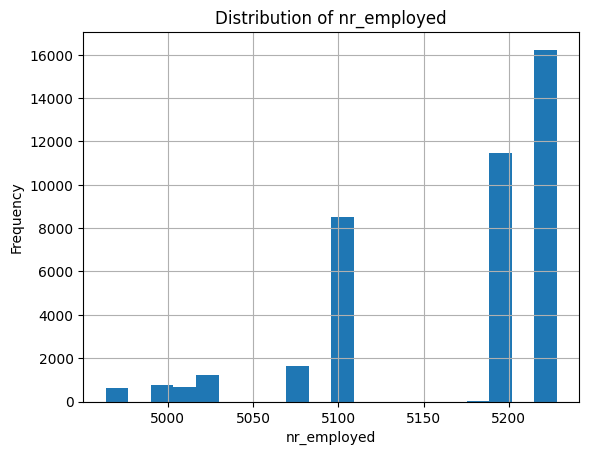

In [76]:
# plot campaign with bins
df.select('nr_employed').toPandas().hist(bins=20)
plt.title("Distribution of nr_employed")
plt.xlabel("nr_employed")
plt.ylabel("Frequency")
plt.show()


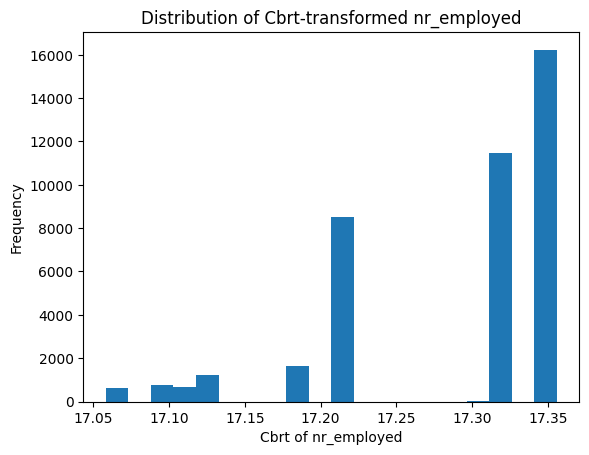

In [78]:
# Assuming 'df' is your Spark DataFrame and 'campaign' is the column you wish to transform.
# Apply logarithmic transformation to 'campaign'.
df = df.withColumn("nr_employed_cbrt", cbrt("nr_employed"))

# Now, you would plot the distribution of the transformed 'campaign' to evaluate the result.
# The following code would be executed in a PySpark environment that supports plotting, like Databricks.
# For local environments, you would collect the data to the driver node and use a local plotting library like matplotlib.

# Collect the data to the driver node. Be cautious with large datasets as this can cause out-of-memory errors.
nr_employed_cbrt_data = df.select('nr_employed_cbrt').rdd.flatMap(lambda x: x).collect()

# Use matplotlib to plot the histogram.
import matplotlib.pyplot as plt

plt.hist(nr_employed_cbrt_data, bins=20)
plt.title('Distribution of Cbrt-transformed nr_employed')
plt.xlabel('Cbrt of nr_employed')
plt.ylabel('Frequency')
plt.show()